# Submission

## Script to generate the YOLO predictions for the test set (20k images, takes around 10 min)

In [ ]:
import os
import glob
import csv
from tqdm import tqdm

import torch
from ultralytics import YOLO
from PIL import Image

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

MODEL_PATH = "11s_640_light.pt"
TEST_IMAGES_DIR = os.path.join("spark-2024-detection-test", "images")
OUTPUT_DIR = "submission_output"

CONF_THRESHOLD = 0.25 # min confidence for prediction

os.makedirs(OUTPUT_DIR, exist_ok=True) # create output dir


def get_test_images(folder):
    """
    Collect and return all test image paths, sorted by filename.
    """
    return sorted(glob.glob(os.path.join(folder, "*.jpg")))


def fallback_bbox(width, height):
    """
    Return a default bounding box if YOLO detects nothing.
    The box is centered and covers roughly 1/4 of the image.
    """
    cx, cy = width // 2, height // 2
    w, h = width // 4, height // 4
    return cx - w // 2, cy - h // 2, cx + w // 2, cy + h // 2


def main():

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load the pretrained YOLO model
    model = YOLO(MODEL_PATH)
    model.to(device)
    model.eval()

    # Mapping from class index to class name
    names = model.names
    print(f"Classes: {names}")

    # Load all test image paths
    image_paths = get_test_images(TEST_IMAGES_DIR)
    print(f"Found {len(image_paths)} test images")

    # Check: only process the first 100 images
    # image_paths = image_paths[:100]

    results = []

    # Run inference image by image
    for img_path in tqdm(image_paths, desc="Running YOLO inference"):
        filename = os.path.basename(img_path)

        # Load image only to get its width and height
        img = Image.open(img_path)
        W, H = img.size

        # Run YOLO prediction on the image
        pred = model.predict(
            source=img_path,
            conf=CONF_THRESHOLD,
            device=device,
            verbose=False
        )[0]

        # If at least one bounding box is detected...
        if pred.boxes is not None and len(pred.boxes) > 0:
            boxes = pred.boxes

            # Select the box with the highest confidence (we need exactly 1 per image)
            best_idx = boxes.conf.argmax().item()

            # Extract bounding box coordinates
            x_min, y_min, x_max, y_max = map(
                int, boxes.xyxy[best_idx].tolist()
            )

            # Get class name
            class_name = names[int(boxes.cls[best_idx].item())]

        # If no detection is found, use a fallback box
        else:
            x_min, y_min, x_max, y_max = fallback_bbox(W, H)
            class_name = list(names.values())[0]

        # Store one row for the submission CSV
        results.append([
            filename,
            class_name,
            f"({x_min}, {y_min}, {x_max}, {y_max})"
        ])

    # Write results to detection.csv
    output_csv = os.path.join(OUTPUT_DIR, "detection.csv")
    with open(output_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["filename", "class", "bbox"])
        writer.writerows(results)

    print(f"Saved detection.csv with {len(results)} entries")


if __name__ == "__main__":
    main()

Using device: cuda
Classes: {0: 'VenusExpress', 1: 'Cheops', 2: 'LisaPathfinder', 3: 'ObservationSat1', 4: 'Proba2', 5: 'Proba3', 6: 'Proba3ocs', 7: 'Smart1', 8: 'Soho', 9: 'XMM Newton'}
Found 20000 test images


Running YOLO inference: 100%|██████████| 20000/20000 [14:54<00:00, 22.37it/s]

Saved detection.csv with 20000 entries


## Show a random prediction on a test image (visually check it, before submitting detection.csv online)

Selected row: {'filename': 'test_01587_img.jpg', 'class': 'Smart1', 'bbox': '(253, 17, 784, 590)'}


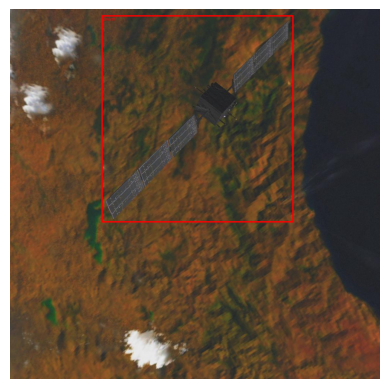

In [121]:
import os
import csv
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Paths
CSV_PATH = "submission_output/detection.csv"
IMAGES_DIR = "spark-2024-detection-test/images"

# Read CSV and pick a random row
with open(CSV_PATH, newline="") as f:
    rows = list(csv.DictReader(f))

row = random.choice(rows)

filename = row["filename"]
class_name = row["class"]
bbox_str = row["bbox"]

print("Selected row:", row)

# Parse bbox string "(xmin, ymin, xmax, ymax)"
x_min, y_min, x_max, y_max = map(int, bbox_str.strip("()").split(","))

# Load image
img_path = os.path.join(IMAGES_DIR, filename)
img = Image.open(img_path).convert("RGB")

# Draw bounding box
draw = ImageDraw.Draw(img)
draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=4)
draw.text((x_min + 5, y_min + 5), class_name, fill="red")

# Show image
plt.imshow(img)
plt.axis("off")
plt.show()
